In [88]:
#!/usr/bin/env python
#Note that this is the manual experiment and in here, I do the augmentation in another notebook when needed.
import torch
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import time
import numpy as np, random
from PIL import Image
import os
import torch.utils.data as data
from skimage import io, transform, img_as_float
import PIL
import random
import pickle
from SemProj.Important import ResNet34, DataSet, ResNet18
import SemProj.randImGen as randImGen


our_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                         (0.2724, 0.2608, 0.2669))
])
tr = transforms.ToPILImage()
BATCH_SIZE = 100
S0_Card = 24*43
LEARNING_RATE = 1e-3
classesNumber = 43 
lmbda=0.1
ITERATIONS = 1
EPOCHS = 1

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
def train_model(trainloader,epochs=1, model=None):
    if model==None:
        model = ResNet34()
        model.to(device)
    loss_function=nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(substitute_model.parameters(), lr=LEARNING_RATE)

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(trainloader):
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad() 
            preds = model(images)
            loss = loss_function(preds,labels)
            loss.backward() 
            optimizer.step() 
            total_loss += loss.item()
        del images
        del labels
    return model

In [81]:
substitute_model = ResNet18()
model_loader = torch.load('./substitute_model',map_location=torch.device('cpu'))
substitute_model.load_state_dict(model_loader['model_state_dict'])
substitute_model = substitute_model.to(device)

In [78]:
training_file = "./SemProj/data_pickle/train_subs_2_5.p"
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']
trainingdataset = DataSet(X_train,y_train,our_transformation)
trainingDataLoader = torch.utils.data.DataLoader(trainingdataset,batch_size=16,shuffle=True)

In [79]:
substitute_model = train_model(trainingDataLoader,1,substitute_model)

100%|██████████| 1/1 [01:13<00:00, 73.72s/it]


In [42]:
testing_file = "./SemProj/data_pickle/test.p"
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']

In [43]:
testingdataset = DataSet(X_test,y_test,our_transformation)
testingDataLoader = torch.utils.data.DataLoader(testingdataset, batch_size=BATCH_SIZE, shuffle=False)

In [44]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(correct)
    return 100 * correct / total

In [45]:
test(substitute_model,testingDataLoader)

8853


70.09501187648456

In [48]:
test(substitute_model,testingDataLoader)

10118


80.11084718923199

In [130]:
test(substitute_model,testingDataLoader)

11494


91.0055423594616

In [63]:
torch.save({'model_state_dict':substitute_model.state_dict(),},'./substitute_model')

In [90]:
nbr_samples = randImGen.randImGen()

In [91]:
nbr_samples

763

In [93]:
BB  = ResNet34()
BB_loader = torch.load('./BlackBox')
BB.load_state_dict(BB_loader['model_state_dict'])
BB.to(device)
print("done!")

done!


In [94]:
class Random_Dataset(torch.utils.data.Dataset):

    def __init__(self, number_images, root_dir, model, transform=None):
        self.number_images = number_images
        self.root_dir = root_dir
        self.transform = transform
        self.model = model

    def __len__(self):
        return self.number_images

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, str(idx+1)+'.jpg')
        image = io.imread(img_name)
        resized_img = transform.resize(image, (32, 32))
        sample = img_as_float(resized_img)

        if self.transform:
            sample = self.transform(sample)
        sample = sample.float()
        sample_to_model = sample.unsqueeze(0).to(device)
        target = self.model(sample_to_model).argmax(dim=1).item()
        del sample_to_model
        return [sample,target]

In [106]:
Random_dataset_BB = Random_Dataset(nbr_samples,
                                './SemProj/random_images',
                                BB,
                                our_transformation)

In [107]:
Random_dataset_sub = Random_Dataset(nbr_samples,
                                './SemProj/random_images',
                                substitute_model,
                                our_transformation)

In [ ]:
ctr = 0
for i in range(len(Random_dataset_BB)):
    if(Random_dataset_BB[i][1]==Random_dataset_sub[i][1]):
        ctr = ctr + 1

In [131]:
print("similarity over randomly generated data = "+str(100*ctr/len(Random_dataset_BB)))

similarity over randomly generated data = 69.0239855832241153


In [132]:
def GoodFelow_sAttack(image, eps, grad):
    sign_data_grad = image.sign()
    perturbed_image = image + eps*sign_data_grad
    return perturbed_image

In [133]:
testingDataLoader = torch.utils.data.DataLoader(testingdataset, batch_size=1, shuffle=False)

In [171]:
loss_function=nn.CrossEntropyLoss()
L = []
for images, labels in testingDataLoader:
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
    outputs = substitute_model(images)
    loss = loss_function(outputs,labels)
    predicted = outputs.argmax(dim=1)
    substitute_model.zero_grad()
    loss.backward()
    grad = images.grad.data
    # I classified correctly, then I need to make it wrong
    if(predicted.item()==labels.item()):
        modified_images = GoodFelow_sAttack(images,0.2,grad)
        pred = substitute_model(modified_images).argmax(dim=1)
        if(pred.item()!=labels.item()):
            x = BB(modified_images).argmax(dim=1)
            if(x.item()==labels.item()):
                L.append([modified_images,images,0])
            else:
                L.append([modified_images,images,1])
    # I classified wrongly since the begining, then I don't care
    else:
        continue

In [172]:
indexes = []
for i in range(len(L)):
    if(L[i][2]==1):
        indexes.append(i)

In [173]:
len(indexes)

195

In [163]:
inv_normalize = transforms.Normalize((-0.3403/0.2724, -0.3121/0.2608, -0.3214/0.2669),
                                    (1/0.2724, 1/0.2608, 1/0.2669))

Original:
Modified:
-------------------------------------------------------------------------------------
Original:
Modified:
-------------------------------------------------------------------------------------
Original:
Modified:
-------------------------------------------------------------------------------------
Original:
Modified:
-------------------------------------------------------------------------------------
Original:
Modified:
-------------------------------------------------------------------------------------


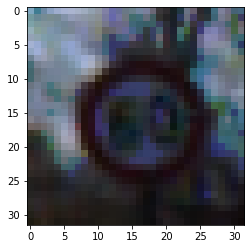

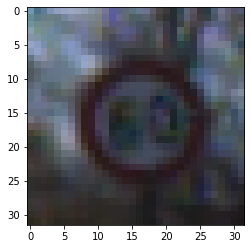

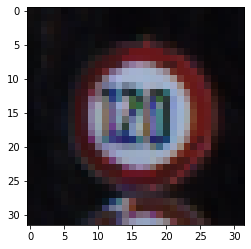

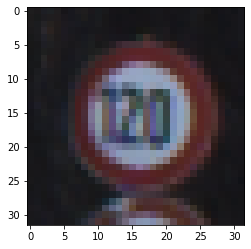

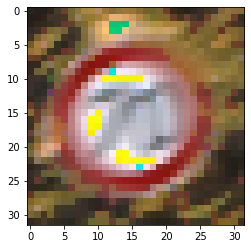

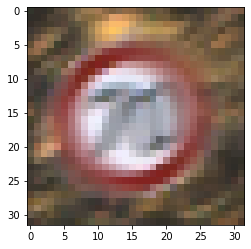

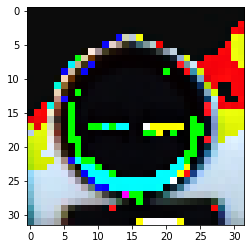

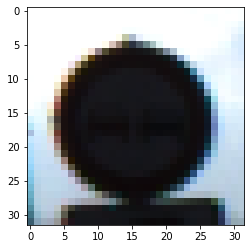

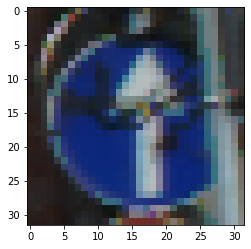

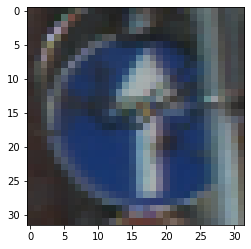

<Figure size 432x288 with 0 Axes>

In [174]:
import matplotlib.pyplot as plt
for i in range(5,10):
    print("Original:")
    plt.imshow(transforms.ToPILImage()(inv_normalize(L[indexes[i]][0]).squeeze(0)).convert("RGB"))
    plt.figure()
    print("Modified:")
    plt.imshow(transforms.ToPILImage()(inv_normalize(L[indexes[i]][1]).squeeze(0)).convert("RGB"))
    plt.figure()
    print("-------------------------------------------------------------------------------------")